# Using `RailEnv`

In this notebook, we will see how to create, interact with and render railway systems with `RailEnv` the flatland env class.

You can run this document as an interactive notebook in one click:

<!-- [![Open In Binder](https://mybinder.org/static/images/badge_logo.svg)](https://mybinder.org/v2/gh/MasterScrat/getting-started/master?filepath=notebook_1.ipynb)[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MasterScrat/getting-started/blob/master/notebook_1.ipynb) -->

## Setup
1. Install Flatland


In [1]:
!pip install -U flatland-rl

## The Environment
Let's first go over the main use cases of `RailEnv`, the Flatland environment.

The basic usage of the `RailEnv` environment consists in creating a `RailEnv` object endowed with
-  a **rail generator**, that generates new rail networks on each reset,
-  a **line generator**, that generates start and end points for each agent on reset,
- an **observation builder**, that provides a suitable observation vector to the agents. 

For now, let's see how we can create rail networks and use them to train agents.



In [7]:
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.line_generators import sparse_line_generator
from flatland.envs.observations import GlobalObsForRailEnv


rail_generator = sparse_rail_generator(max_num_cities=2)

# Initialize the properties of the environment
random_env = RailEnv(
    width=24,
    height=24,
    number_of_agents=1,
    rail_generator=rail_generator,
    line_generator=sparse_line_generator(),
    obs_builder_object=GlobalObsForRailEnv()
)

# Call reset() to initialize the environment
observation, info = random_env.reset()


## Visualising the env

You can use the method `RenderTool.render_env()` to render the env in realtime.

For the sake of this tutorial we define a helper function for inline visualization in the notebook

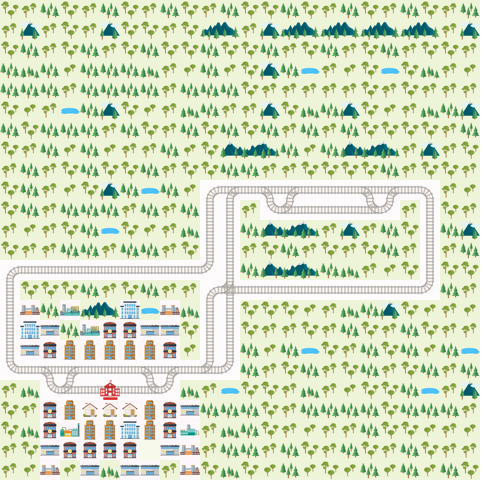

In [8]:
import PIL
from flatland.utils.rendertools import RenderTool
from IPython.display import clear_output


# Render the environment
def render_env(env,wait=True):
    
    env_renderer = RenderTool(env, gl="PILSVG")
    env_renderer.render_env()

    image = env_renderer.get_image()
    pil_image = PIL.Image.fromarray(image)
    clear_output(wait=True)
    display(pil_image)

render_env(random_env)

## Observations

The environment provides very complete observations by default. You typically won't use this object as-is. One of the main objectives of the Flatland challenge is to **find suitable observations** to solve the task at hand.

![stock observations](https://i.imgur.com/oo8EIYv.png)

By default, the environment provides global observations.


In [19]:
import numpy as np

for agent_handle in random_env.get_agent_handles():
    print('Observations for agent {}:'.format(agent_handle))
    agent_obs = observation[agent_handle]

    print('- Transition map\n{}\n'.format(np.transpose(agent_obs[0], (2, 0, 1))))
    print('- Agent position\n{}\n'.format(np.transpose(agent_obs[1], (2, 0, 1))))
    print('- Agent target \n{}\n'.format(np.transpose(agent_obs[2], (2, 0, 1))))

Observations for agent 0:
- Transition map
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0.

## The Agent

`RailEnv` is targeted at multi-agents experiments. For this purpose, it is derived from RLLib's `MultiAgentEnv` class. You can [read more details about it here](https://ray.readthedocs.io/en/latest/rllib-env.html).

The environment is run by supplying the `step` function with a **dictionary** of actions, whose keys are agents’ handles and the corresponding values are the selected actions. This dictionary is passed to the environment which checks the validity of all actions and update the environment state.

The environment returns an array of new observations, a reward dictionary for all the agents as well as a flags indicating which agents are done. This information can be used to update the policy of your agent and if `done[‘__all__’] == True` the episode terminates.

Let us implement a simple agent that takes a valid random action at each step.

In [11]:
class RandomController:
    def __init__(self, action_size):
        self.action_size = action_size

    def act(self, observations):
        actions = dict()
        for agent_handle, observation in enumerate(observations):
            action = np.random.randint(self.action_size)
            actions.update({agent_handle: action})
        return actions

The environment provides a openai gym-like interface.

The env simulation moves forward with the step() method which takes a dictionary of valid actions and returns the following
- observations represeting the state of the env and the **observation generator**
- rewards - the score that rates the agent's performance 
- status of compeletion of tasks for each agent
- additional information regarding the status of the env 

In the example below, we use `env.get_agent_handles()` to enumerate through the handles, and `RailEnvActions.to_char` to get a symbol representing the agent's direction: **B**ackward, **F**orward, **L**eft, **R**ight or **S**top.

In [12]:
from flatland.envs.rail_env import RailEnvActions

controller = RandomController(random_env.action_space[0])
observations, info = random_env.reset()
actions = controller.act(observations)

# Perform a single action per agent
for (handle, action) in actions.items():
    print('Agent {} will perform action {} ({})'.format(handle, action, RailEnvActions.to_char(action)))
    next_obs, all_rewards, dones, info = random_env.step({handle: action})

print('Rewards for each agent: {}'.format(all_rewards))
print('Done for each agent: {}'.format(dones))
print('Misc info: {}'.format(info))

Agent 0 will perform action 2 (F)
Rewards for each agent: {0: 0.0}
Done for each agent: {0: False, '__all__': False}
Misc info: {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.READY_TO_DEPART: 1>}}


In [14]:
def run_episode(env):
    controller = RandomController(env.action_space[0])
    observations, info = env.reset()

    score = 0
    actions = dict()

    for step in range(50):

        actions = controller.act(observations)
        next_observations, all_rewards, dones, info = env.step(actions)
        for agent_handle in env.get_agent_handles():
            score += all_rewards[agent_handle]

        render_env(env)
        print('Timestep {}, total score = {}'.format(step, score))

        if dones['__all__']:
            print('All done!')
            return

    print("Episode didn't finish after 50 timesteps.")

### Run an episode in the random environment

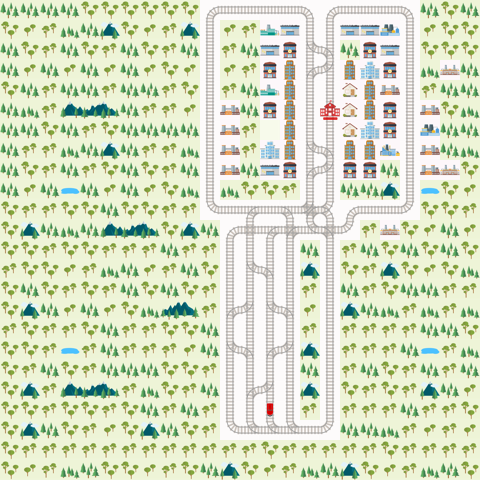

Timestep 45, total score = -26.0
All done!


In [15]:
run_episode(random_env)